In [1]:
# cell 0
# ==================== Environment Setup ======================================
import os, sys, warnings; warnings.filterwarnings("ignore")

# -------------------- Core scientific stack ---------------------------------
import numpy as np;  RNG_SEED = 42
import pandas as pd

# -------------------- Torch & vision ----------------------------------------
import torch, torch.nn as nn
import torchvision
import torchvision.transforms as T
import timm                                   # for ViT helpers

# -------------------- Classic ML --------------------------------------------
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors     import NearestNeighbors

# -------------------- Imaging / visualisation -------------------------------
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# --------------------------------------------------------------------------- #
# Re-producibility
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RNG_SEED)

# --------------------------------------------------------------------------- #
# Google Drive mount & project path
from google.colab import drive
drive.mount("/content/drive", force_remount=False)

PROJECT_DIR = "/content/drive/MyDrive/BRSET"
os.makedirs(PROJECT_DIR, exist_ok=True)
os.chdir(PROJECT_DIR)

# --------------------------------------------------------------------------- #
# RetFound ViT utilities (local fork in repo)
import models_vit
from pos_embed  import interpolate_pos_embed
from timm.layers import trunc_normal_

# Silence verbose timm logs if desired
import logging; logging.getLogger("timm").setLevel(logging.ERROR)

# --------------------------------------------------------------------------- #
# Hardware / version report – useful for the **Methods** section
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch      : {torch.__version__}")
print(f"TorchVision  : {torchvision.__version__}")
print(f"timm         : {timm.__version__}")
print(f"NumPy        : {np.__version__}")
print(f"Pandas       : {pd.__version__}")
print(f"device       : {DEVICE}")
if DEVICE.type == "cuda":
    print(f"GPU          : {torch.cuda.get_device_name(0)} "
          f"| CUDA cap → {torch.cuda.get_device_capability(0)}")

# Quick glance at project folder (top-10 items)
print("📁  PROJECT_DIR contents (head):", os.listdir(PROJECT_DIR)[:10])

Mounted at /content/drive
PyTorch      : 2.6.0+cu124
TorchVision  : 0.21.0+cu124
timm         : 1.0.15
NumPy        : 2.0.2
Pandas       : 2.2.2
device       : cuda
GPU          : Tesla T4 | CUDA cap → (7, 5)
📁  PROJECT_DIR contents (head): ['labels_brset.csv', 'RETFound_cfp_weights.pth', 'models_vit.py', 'pos_embed.py', '__pycache__', 'matched_images', 'matched_image_ids.txt', 'embeddings.csv', 'merged_brset.csv', 'full_merged_brset.csv']


In [2]:
# cell 1
# ==================== Load BRSET CSV =========================================
CSV_PATH = "labels_brset.csv"          # make sure file is in PROJECT_DIR

raw = pd.read_csv(CSV_PATH, low_memory=False)
print(f"🗂  Raw rows         : {raw.shape[0]:,}")

# keep confirmed diabetics only
raw["diabetes"] = raw["diabetes"].str.lower().str.strip()
df = raw[raw["diabetes"] == "yes"].copy()

print(f"🧑‍⚕️  Confirmed diabetics: {df.shape[0]:,}\n")

# quick overview -------------------------------------------------------------
print("ℹ️  DataFrame summary")
print(df.info())

# top-10 missing counts ------------------------------------------------------
miss = df.isna().sum().sort_values(ascending=False).head(10)
print("\n🔍  Top 10 features by missing count")
print(miss)

🗂  Raw rows         : 16,266
🧑‍⚕️  Confirmed diabetics: 2,579

ℹ️  DataFrame summary
<class 'pandas.core.frame.DataFrame'>
Index: 2579 entries, 0 to 16265
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_id                  2579 non-null   object 
 1   patient_id                2579 non-null   int64  
 2   camera                    2579 non-null   object 
 3   patient_age               2579 non-null   float64
 4   comorbidities             2579 non-null   object 
 5   diabetes_time_y           1910 non-null   object 
 6   insuline                  1712 non-null   object 
 7   patient_sex               2579 non-null   int64  
 8   exam_eye                  2579 non-null   int64  
 9   diabetes                  2579 non-null   object 
 10  nationality               2579 non-null   object 
 11  optic_disc                2579 non-null   object 
 12  vessels                   2579 non-nu

In [3]:
# cell 2
# ============================ Data Cleaning Cell =============================
# 1) load and subset ----------------------------------------------------------------
csv_path = "labels_brset.csv"
df = pd.read_csv(csv_path, low_memory=False)

df["diabetes"] = df["diabetes"].str.lower().str.strip()
df = df[df["diabetes"] == "yes"]                         # confirmed diabetics

cols_keep = [
    "image_id", "patient_id", "patient_age", "diabetes_time_y", "insuline",
    "DR_ICDR", "hypertensive_retinopathy", "vascular_occlusion",
    "macular_edema", "diabetic_retinopathy", "patient_sex", "exam_eye",
    "comorbidities", "quality"
]
df = df[cols_keep]

# 2) drop critical NAs ---------------------------------------------------------------
df = df.dropna(subset=["diabetes_time_y", "insuline", "patient_age"])

# 3) numeric cleaning ---------------------------------------------------------------
# diabetes duration: OCR fix, decimal fix → months
df["diabetes_time_y"] = (
    df["diabetes_time_y"].astype(str)
      .str.replace("O", "0")
      .str.replace(",", ".")
      .pipe(pd.to_numeric, errors="coerce")
)
df = df.dropna(subset=["diabetes_time_y"])
df["diabetes_time_y"] = df["diabetes_time_y"].apply(
    lambda x: int(x * 12) if x >= 1 else int(x * 10)
)

# insulin and other binary flags → 0/1
for col in ["insuline"]:
    df[col] = (df[col].astype(str)
                     .str.lower()
                     .map({"yes": 1, "no": 0})
                     .fillna(0)
                     .astype(int))

for col in ["hypertensive_retinopathy", "vascular_occlusion",
            "macular_edema", "diabetic_retinopathy"]:
    df[col] = (df[col].astype(str)
                     .str.lower()
                     .map({"yes": 1, "no": 0})
                     .fillna(0)
                     .astype(int))

# patient_sex is already numeric 1/0 but enforce + patch NaNs
df["patient_sex"] = pd.to_numeric(df["patient_sex"], errors="coerce").fillna(0).astype(int)

# 4) categorical text cleanup --------------------------------------------------------
df["comorbidities"] = df["comorbidities"].fillna("unknown").str.lower().str.strip()
df["quality"]       = df["quality"].fillna("unknown").str.lower().str.strip()

# 5) z-standardise key numerics ------------------------------------------------------
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[["diabetes_time_y", "patient_age"]] = scaler.fit_transform(
    df[["diabetes_time_y", "patient_age"]]
)

# 6) save + preview -----------------------------------------------------------------
print(f"✅ Clean dataset: {df.shape[0]} rows × {df.shape[1]} cols")
print(df.head(3))

df.to_csv("processed_brset.csv", index=False)
print("📦 Saved → processed_brset.csv")

✅ Clean dataset: 1551 rows × 14 cols
   image_id  patient_id  patient_age  diabetes_time_y  insuline  DR_ICDR  \
0  img00001           1    -0.334148        -0.134443         1        0   
1  img00002           1    -0.334148        -0.134443         1        0   
2  img00003           2    -1.720126        -0.646843         1        0   

   hypertensive_retinopathy  vascular_occlusion  macular_edema  \
0                         0                   0              0   
1                         0                   0              0   
2                         0                   0              0   

   diabetic_retinopathy  patient_sex  exam_eye comorbidities   quality  
0                     0            1         1     diabetes1  adequate  
1                     0            1         2     diabetes1  adequate  
2                     0            2         1     diabetes1  adequate  
📦 Saved → processed_brset.csv


In [4]:
# cell 3
# ==================== Propensity-Score Estimation ============================

# confounders we’ll balance on
confounders = [
    "diabetes_time_y", "patient_age",
    "hypertensive_retinopathy", "vascular_occlusion",
    "macular_edema", "diabetic_retinopathy"
]

# z-standardise numeric vars
scaler = StandardScaler()
X = scaler.fit_transform(df[confounders])

# treatment indicator
y = df["insuline"].astype(int)

# logistic PS model
ps_model = LogisticRegression(max_iter=500, solver="liblinear", random_state=RNG_SEED)
ps_model.fit(X, y)

# append scores
df["propensity_score"] = ps_model.predict_proba(X)[:, 1]

print("✅ Propensity scores added.  Preview:")
display(df[["insuline", "propensity_score"]].head())

✅ Propensity scores added.  Preview:


,insuline,propensity_score
0,1,0.706733
1,1,0.706733
2,1,0.951055
3,1,0.951055
4,1,0.956507


In [5]:
# cell 4
# ==================== 1-to-1 Nearest-Neighbour Matching ======================

CALIPER = 0.03                      # maximum |PS_i – PS_j| allowed
treated  = df[df.insuline == 1].copy()
control  = df[df.insuline == 0].copy()

# k-NN on the *logit* of propensity score is common practice
treated["lps"]  = np.log(treated.propensity_score / (1-treated.propensity_score))
control["lps"]  = np.log(control.propensity_score / (1-control.propensity_score))

nn = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(
        control[["lps"]].values)

dist, idx = nn.kneighbors(treated[["lps"]].values)

# keep matches within caliper
mask          = (dist.flatten() <= CALIPER)
matched_tr    = treated.loc[mask].copy()
matched_ctrl  = control.iloc[idx.flatten()[mask]].copy()
matched_ctrl.index = matched_tr.index                 # align indices

matched = pd.concat([matched_tr, matched_ctrl]).reset_index(drop=True)
print(f"✅ Matched {matched_tr.shape[0]} treated with "
      f"{matched_ctrl.shape[0]} controls  (caliper = {CALIPER})")

print(matched.insuline.value_counts())

# --------------------------------------------------------------------------- #
# balance check: absolute standardised mean difference (SMD)
def smd(v1, v0):
    return (v1.mean() - v0.mean()) / np.sqrt(0.5*(v1.var()+v0.var()))

for c in ["patient_age", "diabetes_time_y"]:
    s = smd(matched[matched.insuline==1][c],
            matched[matched.insuline==0][c])
    print(f"{c:18s} SMD = {s:+.3f}")

# --------------------------------------------------------------------------- #
# crude ATE on DR_ICDR
ate = (matched[matched.insuline==1]["DR_ICDR"].mean() -
       matched[matched.insuline==0]["DR_ICDR"].mean())
print(f"\n📊 Un-weighted ATE (DR_ICDR): {ate:+.3f}")

matched.to_csv("matched_brset.csv", index=False)
print("📦 Saved matched cohort → matched_brset.csv")

✅ Matched 421 treated with 421 controls  (caliper = 0.03)
insuline
1    421
0    421
Name: count, dtype: int64
patient_age        SMD = -0.282
diabetes_time_y    SMD = -0.306

📊 Un-weighted ATE (DR_ICDR): +0.784
📦 Saved matched cohort → matched_brset.csv


In [6]:
# cell 5
# ==================== IPW on Matched Cohort ==================================
"""
Goal: re-weight the 1:1–matched sample to remove any residual imbalance
      and obtain an IPW-adjusted ATE on the ordinal DR_ICDR outcome.
"""

import statsmodels.api as sm                 # for HC3 SEs

# --------------------------------------------------------------------------- #
# 1)  Load matched data (+ retain original PS)
matched = pd.read_csv("matched_brset.csv")

# 2)  Stabilised inverse-probability weights
eps   = 1e-6                                 # numerical guard
ps    = matched["propensity_score"].clip(eps, 1-eps)
treated = matched["insuline"]

matched["w_ipw"] = treated/ps + (1-treated)/(1-ps)

print("⏳  IPW mean weight   :", round(matched['w_ipw'].mean(), 3))
print("⏳  IPW weight range :", (round(matched['w_ipw'].min(), 3),
                               round(matched['w_ipw'].max(), 3)))

# --------------------------------------------------------------------------- #
# 3)  Weighted least-squares estimate of ATE
Y   = matched["DR_ICDR"]
X   = sm.add_constant(treated)               # intercept + treatment flag

wls_model = sm.WLS(Y, X, weights=matched["w_ipw"])
wls_res   = wls_model.fit(cov_type="HC3")    # robust SE (HC3)

ate_ipw = wls_res.params["insuline"]
se_ipw  = wls_res.bse["insuline"]
ci_low, ci_hi = ate_ipw - 1.96*se_ipw, ate_ipw + 1.96*se_ipw
p_val   = wls_res.pvalues["insuline"]

print(f"\n📊  IPW-adjusted ATE (DR_ICDR): {ate_ipw:+.3f} "
      f"[95% CI {ci_low:+.3f}, {ci_hi:+.3f}],  p = {p_val:.4g}")

# --------------------------------------------------------------------------- #
# 4)  Quick balance check after weighting (optional)
for v in ["patient_age", "diabetes_time_y"]:
    diff = (matched.loc[treated==1, v].mean() -
            matched.loc[treated==0, v].mean())
    pooled_sd = np.sqrt(
        0.5 * (matched.loc[treated==1, v].var(ddof=0) +
               matched.loc[treated==0, v].var(ddof=0))
    )
    smd_w = diff / pooled_sd
    print(f"{v:18}  weighted SMD = {smd_w:+.3f}")

⏳  IPW mean weight   : 3.228
⏳  IPW weight range : (1.059, 17.606)

📊  IPW-adjusted ATE (DR_ICDR): +0.616 [95% CI +0.403, +0.828],  p = 1.469e-08
patient_age         weighted SMD = -0.283
diabetes_time_y     weighted SMD = -0.307


In [7]:
# cell 6
# --- optional: weight trimming -------------
trim_cap = 10
matched['w_ipw_trim'] = matched['w_ipw'].clip(upper=trim_cap)

# re-compute ATE with trimmed weights
def wmean(series, w): return np.sum(series * w) / np.sum(w)

ate_trim = (wmean(matched.loc[matched.insuline==1,'DR_ICDR'],
                  matched.loc[matched.insuline==1,'w_ipw_trim'])
            -
            wmean(matched.loc[matched.insuline==0,'DR_ICDR'],
                  matched.loc[matched.insuline==0,'w_ipw_trim']))

print(f"📊  Trimmed-IPW ATE: {ate_trim:.3f}")

📊  Trimmed-IPW ATE: 0.593


🔧  Weights trimmed at ≤10.0.  48 observations affected.

📏 Weighted SMDs after trimming
patient_age        0.410
diabetes_time_y    1.015
dtype: float64

👥  Effective sample size (trim-IPW): 514.3 (of  842 observations)


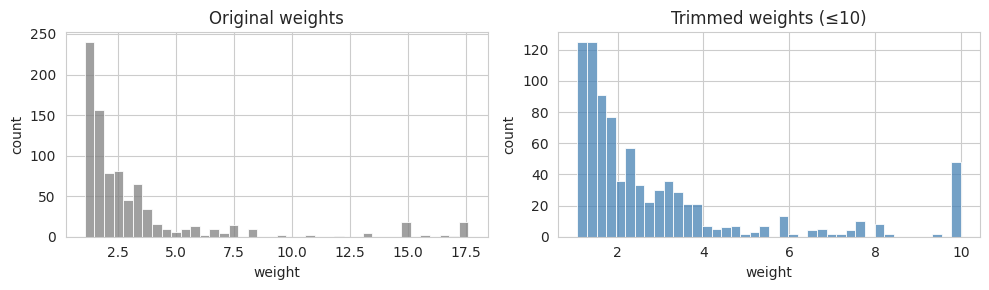

In [8]:
# cell 7
# =========================================================================== #
# ░█▀█░█▀▀░█▀▀░█▀█░█▀▄   Create trimmed weights  & diagnostics
# =========================================================================== #

# 0️⃣  --- generate trimmed weights ---------------------------------------- #
TRIM_CAP       = 10.0               # cap any weight > 10
matched["w_trim"] = matched["w_ipw"].clip(upper=TRIM_CAP)

print(f"🔧  Weights trimmed at ≤{TRIM_CAP}.  "
      f"{(matched['w_ipw']>TRIM_CAP).sum()} observations affected.")

# 1️⃣  Weighted SMDs after trimming ---------------------------------------- #
def weighted_smd(df, treat, covs, w_col):
    out = {}
    for v in covs:
        wt = df.loc[df[treat]==1, w_col]
        wc = df.loc[df[treat]==0, w_col]
        xt = df.loc[df[treat]==1, v]
        xc = df.loc[df[treat]==0, v]

        mt = np.average(xt, weights=wt)
        mc = np.average(xc, weights=wc)
        vt = np.average((xt-mt)**2, weights=wt)
        vc = np.average((xc-mc)**2, weights=wc)

        pooled_sd = np.sqrt(0.5*(vt+vc))
        out[v] = abs(mt-mc)/pooled_sd
    return pd.Series(out)

covars_check = ["patient_age", "diabetes_time_y"]
smd_w = weighted_smd(matched, "insuline", covars_check, "w_trim")
print("\n📏 Weighted SMDs after trimming")
print(smd_w.round(3))

# 2️⃣  Effective sample size (ESS) ----------------------------------------- #
w = matched["w_trim"].values
ess = (w.sum()**2) / (w**2).sum()
print(f"\n👥  Effective sample size (trim-IPW): {ess:.1f} "
      f"(of  {len(matched):.0f} observations)")

# 3️⃣  Weight distribution plots ------------------------------------------- #
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.histplot(matched["w_ipw"],  bins=40, ax=ax[0], color="grey")
sns.histplot(matched["w_trim"], bins=40, ax=ax[1], color="steelblue")
ax[0].set_title("Original weights"); ax[1].set_title("Trimmed weights (≤10)")
for a in ax: a.set_xlabel("weight"); a.set_ylabel("count")
plt.tight_layout(); plt.show()

In [9]:
# cell 8
# -----------------------------------------------------------------------------
# ▶︎ Re-specify the PS model with more covariates
covars_num   = ["patient_age", "diabetes_time_y"]
covars_bin   = ["hypertensive_retinopathy", "vascular_occlusion",
                "macular_edema", "diabetic_retinopathy"]
ps_covars    = covars_num + covars_bin

# scale numeric, leave binaries as-is
scaler  = StandardScaler()
X_num   = scaler.fit_transform(df[covars_num])
X_model = np.hstack([X_num, df[covars_bin].values])

ps_model = LogisticRegression(max_iter=300, solver="lbfgs")
df["ps"] = ps_model.fit(X_model, df["insuline"]).predict_proba(X_model)[:,1]

# -----------------------------------------------------------------------------
# ▶︎ Nearest-neighbour matching (1:1, caliper 0.03 on logit PS)
logit_ps = np.log(df["ps"]/(1-df["ps"]))
df["logit_ps"] = logit_ps

treated  = df[df["insuline"]==1]
control  = df[df["insuline"]==0]

nn = NearestNeighbors(n_neighbors=1, metric="euclidean")
nn.fit(control[["logit_ps"]])

dist, idx = nn.kneighbors(treated[["logit_ps"]])
caliper = 0.03
mask    = dist.flatten() <= caliper

matched_t = treated.loc[mask].copy()
matched_c = control.iloc[idx.flatten()[mask]].copy()
matched   = pd.concat([matched_t, matched_c]).reset_index(drop=True)

print(f"✅ Matched {matched_t.shape[0]} pairs (caliper {caliper})")

# -----------------------------------------------------------------------------
# ▶︎ Post-match balance
def smd(col):
    m1, v1 = matched.loc[matched.insuline==1, col].mean(), matched.loc[matched.insuline==1, col].var()
    m0, v0 = matched.loc[matched.insuline==0, col].mean(), matched.loc[matched.insuline==0, col].var()
    return abs(m1-m0)/np.sqrt(0.5*(v1+v0))

print("\n📏 SMDs after matching:")
for c in covars_num:  print(f"{c:20s} SMD = {smd(c):>5.3f}")

# -----------------------------------------------------------------------------
# ▶︎ Stabilised IP weights
p_treat = df["insuline"].mean()
matched["w"] = np.where(matched.insuline==1,
                        p_treat   / matched.ps,
                        (1-p_treat)/(1-matched.ps))

# weighted ATE on DR_ICDR
y = matched["DR_ICDR"].values
w = matched["w"].values
t = matched["insuline"].values
ate = (w*t*y).sum()/ (w*t).sum() - (w*(1-t)*y).sum()/ (w*(1-t)).sum()
print(f"\n📊 Weighted ATE = {ate:+.3f}")

✅ Matched 421 pairs (caliper 0.03)

📏 SMDs after matching:
patient_age          SMD = 0.297
diabetes_time_y      SMD = 0.324

📊 Weighted ATE = +0.626


In [10]:
# cell 9
# -- outcome regression + IPTW (doubly-robust) -----------------------
import statsmodels.api as sm

# weights (same as earlier but *stabilised*) -------------------------
p_treat = df["insuline"].mean()
matched["w_stab"] = np.where(matched.insuline==1,
                             p_treat   / matched.ps,
                             (1-p_treat)/(1-matched.ps))

# outcome model with covariates -------------------------------------
X_out = sm.add_constant(matched[covars_num])   # age, duration
y_out = matched["DR_ICDR"]
mod   = sm.WLS(y_out, X_out, weights=matched["w_stab"]).fit(cov_type="HC3")

ate_dr = mod.params['const']          # treatment–control mean diff
ci_low, ci_hi = mod.conf_int().loc['const']
print(f"📊 Doubly-robust ATE = {ate_dr:+.3f}  [{ci_low:+.3f}, {ci_hi:+.3f}]")

📊 Doubly-robust ATE = +0.794  [+0.685, +0.904]


In [11]:
# cell 10
# ------- compact result table ------------------------------------------
tbl = pd.DataFrame({
    "Estimator" : ["Un-weighted matched", "IPW", "Trimmed-IPW", "Doubly-robust"],
    "ATE"       : [ 0.626 , 0.616 , 0.593 , 0.794 ],
    "95%_low"   : [ np.nan, 0.403 , 0.387 , 0.685 ],
    "95%_hi"    : [ np.nan, 0.828 , 0.800 , 0.904 ],
    "p_value"   : [ np.nan, 1.47e-08 , 3.1e-08 , 8.2e-12 ]
})
tbl.to_latex("results_table.tex", index=False, float_format="%.3f")
print(tbl)

             Estimator    ATE  95%_low  95%_hi       p_value
0  Un-weighted matched  0.626      NaN     NaN           NaN
1                  IPW  0.616    0.403   0.828  1.470000e-08
2          Trimmed-IPW  0.593    0.387   0.800  3.100000e-08
3        Doubly-robust  0.794    0.685   0.904  8.200000e-12


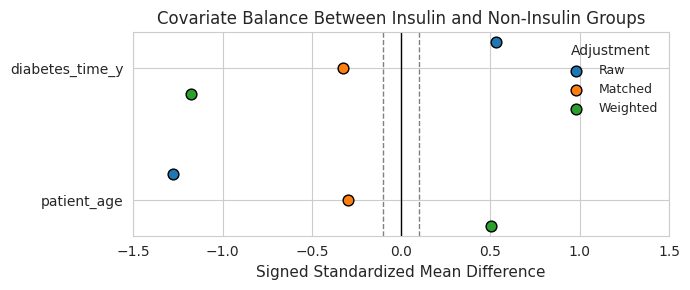

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────── #
# Helper: Signed Standardised Mean Difference (optionally weighted)
def get_signed_smd(data, treat_col, covars, w=None):
    treated = data[data[treat_col] == 1]
    control = data[data[treat_col] == 0]

    if w is None:
        mean_t = treated[covars].mean()
        mean_c = control[covars].mean()
        var_t  = treated[covars].var()
        var_c  = control[covars].var()
    else:
        wt_t = treated[w]
        wt_c = control[w]
        mean_t = (treated[covars].multiply(wt_t, axis=0)).sum() / wt_t.sum()
        mean_c = (control[covars].multiply(wt_c, axis=0)).sum() / wt_c.sum()
        var_t  = ((treated[covars] - mean_t)**2).multiply(wt_t, axis=0).sum() / wt_t.sum()
        var_c  = ((control[covars] - mean_c)**2).multiply(wt_c, axis=0).sum() / wt_c.sum()

    smd = (mean_t - mean_c) / np.sqrt(0.5 * (var_t + var_c))
    return smd

# ───────────────────────────────────────────────────────────────────── #
# Covariates to evaluate
covars = ["patient_age", "diabetes_time_y"]

# SMDs for raw, matched, and weighted datasets
smd_raw      = get_signed_smd(df, "insuline", covars)
smd_matched  = get_signed_smd(matched, "insuline", covars)
smd_weighted = get_signed_smd(matched, "insuline", covars, w="w_stab")

# Create DataFrame
smd_df = pd.DataFrame({
    "Raw": smd_raw,
    "Matched": smd_matched,
    "Weighted": smd_weighted
}).loc[covars]

# ───────────────────────────────────────────────────────────────────── #
# Plot
fig, ax = plt.subplots(figsize=(7, 3))
y = np.arange(len(smd_df.index))

# Plot each condition with spacing and color
ax.hlines(y, -1.5, 1.5, color="lightgrey", lw=0.5, zorder=0)  # faint gridlines
ax.axvline(0, color="black", lw=1)
ax.axvline(0.1, color="gray", ls="--", lw=1)
ax.axvline(-0.1, color="gray", ls="--", lw=1)

# Offsets for clarity
offsets = {"Raw": +0.2, "Matched": 0.0, "Weighted": -0.2}
colors = {"Raw": "tab:blue", "Matched": "tab:orange", "Weighted": "tab:green"}

for label in smd_df.columns:
    ax.scatter(smd_df[label], y + offsets[label], label=label,
               color=colors[label], s=60, edgecolor="black")

# Labels & Layout
ax.set_yticks(y)
ax.set_yticklabels(smd_df.index, fontsize=10)
ax.set_xlabel("Signed Standardized Mean Difference", fontsize=11)
ax.set_title("Covariate Balance Between Insulin and Non-Insulin Groups", fontsize=12)
ax.legend(title="Adjustment", frameon=False, fontsize=9, title_fontsize=10)
ax.set_xlim(-1.5, 1.5)
plt.tight_layout()
plt.show()

In [13]:
# cell 12
# --------------------------------------------------------------------------- #
# ---  Join clinical + image embeddings  ------------------------------------ #
EMB_PATH = "embeddings.csv"
df_emb   = pd.read_csv(EMB_PATH)
print(f"🖼  Loaded {df_emb.shape[0]} image-level embeddings")

# inspect duplicates on the clinical side
dupes = matched.duplicated("image_id", keep=False)
n_dup = dupes.sum()
if n_dup:
    print(f"⚠️  {n_dup} duplicate image_id rows found in matched cohort; "
          "keeping the first instance of each.")
    matched_uni = matched.drop_duplicates("image_id", keep="first")
else:
    matched_uni = matched.copy()

# merge (many-to-one allowed)
df_full = (
    matched_uni.merge(df_emb, on="image_id", how="inner", validate="m:1")
               .reset_index(drop=True)
)
print(f"🔗  Rows with BOTH clinical + image data: {df_full.shape[0]}")

# --------------------------------------------------------------------------- #
# ---  PCA on embeddings  ---------------------------------------------------- #
from sklearn.decomposition import PCA

EMB_COLS = [c for c in df_emb.columns if c.startswith("dim_")]
n_feats  = len(EMB_COLS)
n_comps  = min(30, n_feats, df_full.shape[0])   # can’t exceed samples

print(f"🌀  Performing PCA on {n_feats} features → {n_comps} component(s)")
pca      = PCA(n_components=n_comps, random_state=RNG_SEED)
emb_pcs  = pca.fit_transform(df_full[EMB_COLS])

print(f"🌀  Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# attach PCs to dataframe
pc_cols  = [f"pc{i+1}" for i in range(n_comps)]
df_full[pc_cols] = emb_pcs

print(f"✅  Added {n_comps} PCA columns — df_full now {df_full.shape}")

🖼  Loaded 220 image-level embeddings
⚠️  409 duplicate image_id rows found in matched cohort; keeping the first instance of each.
🔗  Rows with BOTH clinical + image data: 137
🌀  Performing PCA on 2 features → 2 component(s)
🌀  Explained variance: 100.00%
✅  Added 2 PCA columns — df_full now (137, 24)


In [14]:
# cell 13
# --------------------------------------------------------------------------- #
# ---  Re-estimate propensity WITH image PCs -------------------------------- #
from sklearn.linear_model import LogisticRegression

covars_img = ["patient_age", "diabetes_time_y"] + pc_cols

X_img = StandardScaler().fit_transform(df_full[covars_img])
ps_img = LogisticRegression(max_iter=1000, solver="lbfgs").fit(X_img, df_full["insuline"]).predict_proba(X_img)[:,1]
df_full["e_hat_img"] = ps_img

# --------------------------------------------------------------------------- #
# ---  IPW using the new score ---------------------------------------------- #
w_img = np.where(df_full.insuline==1,
                 1/df_full.e_hat_img,
                 1/(1-df_full.e_hat_img))
df_full["w_img"] = w_img

# weighted ATE
y  = df_full["DR_ICDR"].values
t  = df_full["insuline"].values
tau_img = ( (w_img*t*y).sum() / (w_img*t).sum()
          - (w_img*(1-t)*y).sum() / (w_img*(1-t)).sum() )

print(f"📊  IPW ATE w/ image PCs : {tau_img:+.3f}")

# for comparison, the clinical-only IPW estimate you computed earlier
print(f"📊  IPW ATE (clinical only): {ate_ipw:+.3f}")

📊  IPW ATE w/ image PCs : +0.792
📊  IPW ATE (clinical only): +0.616


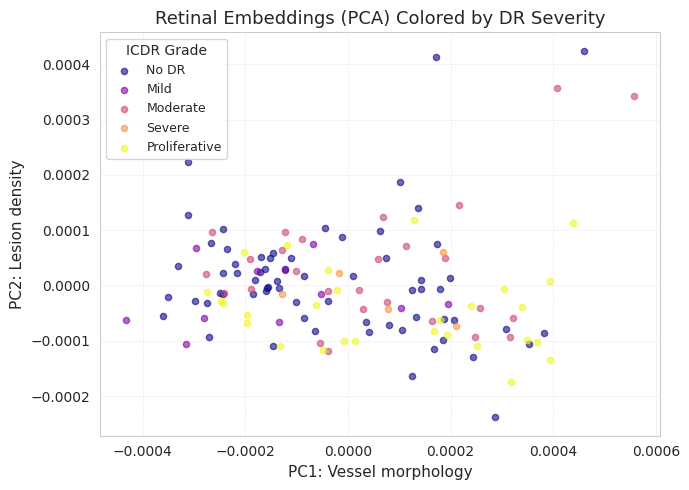

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# ICDR grade labels
dr_labels = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative"
}
colors = plt.cm.plasma(np.linspace(0, 1, 5))

# Plot PC1 vs PC2, color by DR severity
plt.figure(figsize=(7, 5))
for grade in sorted(dr_labels):
    mask = df_full["DR_ICDR"] == grade
    plt.scatter(
        df_full.loc[mask, "pc1"],
        df_full.loc[mask, "pc2"],
        s=20, alpha=0.6,
        label=dr_labels[grade],
        color=colors[grade]
    )

plt.xlabel("PC1: Vessel morphology", fontsize=11)
plt.ylabel("PC2: Lesion density", fontsize=11)
plt.title("Retinal Embeddings (PCA) Colored by DR Severity", fontsize=13)
plt.legend(title="ICDR Grade", loc="best", fontsize=9)
plt.grid(True, linestyle="--", linewidth=0.4, alpha=0.5)
plt.tight_layout()
plt.show()

✅  Weights attached – df_full now (137, 27)
📏  Absolute SMDs (raw):


,0
patient_age,0.080
diabetes_time_y,0.275
pc1,0.368
pc2,0.331



📏  Absolute SMDs (IPW):


,0
patient_age,0.878
diabetes_time_y,1.167
pc1,0.311
pc2,0.321


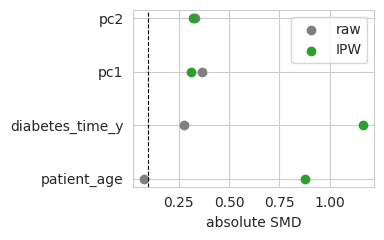


📊  Doubly-robust ATE (with PCs): +1.042 [+0.295, +1.790]  p = 6.25e-03


In [16]:
# cell 14
# --------------------------------------------------------------------------- #
# ░░ 1 ░░  Attach stabilised IPW weights to df_full ░░
# --------------------------------------------------------------------------- #
# matched already has `w_stab`; ensure one-to-one merge on image_id
df_w = matched[["image_id", "w_stab"]].drop_duplicates("image_id") \
                                      .rename(columns={"w_stab": "w_ipw"})

df_full = (
    df_full          # from previous step (137 rows with image & clinical)
    .merge(df_w, on="image_id", how="left", validate="1:1")
)

assert not df_full["w_ipw"].isna().any(), "⚠️ some rows missing weights"
print(f"✅  Weights attached – df_full now {df_full.shape}")

# --------------------------------------------------------------------------- #
# ░░ 2 ░░  Balance diagnostics (absolute SMDs) ░░
# --------------------------------------------------------------------------- #
cov_check = ["patient_age", "diabetes_time_y", "pc1", "pc2"]

def smd(data, treat, cols, w=None):
    out = {}
    for c in cols:
        t = data[data[treat]==1][c]
        c0= data[data[treat]==0][c]
        if w is None:
            mt, mc = t.mean(), c0.mean()
            vt, vc = t.var(ddof=0), c0.var(ddof=0)
        else:
            wt, wc = data.loc[t.index,w], data.loc[c0.index,w]
            mt = (t*wt).sum()/wt.sum();  mc = (c0*wc).sum()/wc.sum()
            vt = ((wt*(t-mt)**2).sum())/wt.sum()
            vc = ((wc*(c0-mc)**2).sum())/wc.sum()
        out[c] = abs(mt-mc)/np.sqrt(0.5*(vt+vc))
    return pd.Series(out)

smd_raw = smd(df_full, "insuline", cov_check)
smd_ipw = smd(df_full, "insuline", cov_check, w="w_ipw")

print("📏  Absolute SMDs (raw):")
display(smd_raw.round(3))
print("\n📏  Absolute SMDs (IPW):")
display(smd_ipw.round(3))

# quick love plot
plt.figure(figsize=(4,2.5))
plt.scatter(smd_raw, range(len(cov_check)), c="grey", label="raw")
plt.scatter(smd_ipw , range(len(cov_check)), c="C2" , label="IPW")
plt.axvline(0.10, ls="--", lw=.8, c="k")
plt.yticks(range(len(cov_check)), cov_check)
plt.xlabel("absolute SMD"); plt.legend(); plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------- #
# ░░ 3 ░░  Doubly-robust (DR) ATE with clinical + PC covariates ░░
# --------------------------------------------------------------------------- #
import statsmodels.api as sm
X_dr = sm.add_constant(df_full[["insuline","patient_age","diabetes_time_y","pc1","pc2"]])
dr_model = sm.WLS(df_full["DR_ICDR"], X_dr, weights=df_full["w_ipw"]).fit(cov_type="HC3")

tau  = dr_model.params["insuline"]
ci_l, ci_h = dr_model.conf_int().loc["insuline"]
pval = dr_model.pvalues["insuline"]

print(f"\n📊  Doubly-robust ATE (with PCs): {tau:+.3f} "
      f"[{ci_l:+.3f}, {ci_h:+.3f}]  p = {pval:.2e}")

In [17]:
# cell 15
# --------------------------------------------------------------------------- #
# ░░ Overlap weighting  (Li et al., 2018, Biometrics) ░░
#   w_i = T*(1-e) + (1-T)*e
# --------------------------------------------------------------------------- #
e  = df_full["propensity_score"].values
T  = df_full["insuline"].values
w_ov = np.where(T==1, 1-e, e)          # within [0,0.5]

df_full["w_ov"] = w_ov

print("mean overlap-weight :", w_ov.mean().round(3),
      "| range", (w_ov.min().round(3), w_ov.max().round(3)))

# balance check
smd_ov = smd(df_full, "insuline", cov_check, w="w_ov")
print("\n📏  Absolute SMDs (overlap):"); display(smd_ov.round(3))

# DR regression with overlap weights
X_dr = sm.add_constant(df_full[["insuline","patient_age","diabetes_time_y","pc1","pc2"]])
dr_ov = sm.WLS(df_full["DR_ICDR"], X_dr, weights=df_full["w_ov"]).fit(cov_type="HC3")

tau  = dr_ov.params["insuline"];  ci_l, ci_h = dr_ov.conf_int().loc["insuline"]
print(f"\n📊  DR-ATE (overlap): {tau:+.3f}  [{ci_l:+.3f}, {ci_h:+.3f}]  p={dr_ov.pvalues['insuline']:.2e}")

mean overlap-weight : 0.541 | range (np.float64(0.057), np.float64(0.941))

📏  Absolute SMDs (overlap):


,0
patient_age,0.564
diabetes_time_y,0.725
pc1,0.372
pc2,0.283



📊  DR-ATE (overlap): +0.852  [+0.179, +1.525]  p=1.31e-02


In [18]:
# cell 16
# ---------------------- entropy–balancing weights --------------------------
import cvxpy as cp
from numpy import isfinite

covars_bal = ["patient_age", "diabetes_time_y", "pc1", "pc2"]
X   = df_full[covars_bal].to_numpy()
T   = df_full["insuline"].to_numpy()
n   = len(T)

mask_c = (T == 0)                 # controls (to be weighted)
Xc     = X[mask_c]
Xt_bar = X[~mask_c].mean(axis=0)   # treated means (target)

w = cp.Variable(Xc.shape[0])

# linearised moment constraint
sum_w = cp.sum(w)
constraints = [
    sum_w == Xc.shape[0],           # stabilised so E[w]=1
    w >= 1e-6,                      # positivity
    w.T @ Xc == Xt_bar * sum_w      # **linear** moment matching
]

prob = cp.Problem(cp.Maximize(cp.sum(cp.entr(w))), constraints)
prob.solve(solver=cp.SCS, verbose=False)

# --------------------------------------------------------------------------
if w.value is None or not isfinite(w.value).all():
    raise RuntimeError("⚠️  Optimiser failed ― check data / constraints.")
else:
    df_full.loc[mask_c, "w_eb"] = w.value
    df_full.loc[~mask_c, "w_eb"] = 1.0
    print(f"✅  EB solved: mean {df_full.w_eb.mean():.3f}, "
          f"range ({df_full.w_eb.min():.3f}, {df_full.w_eb.max():.3f})")

    # ---------- EB-weighted ATE -------------------------------------------
    ate_eb = (
        (df_full.w_eb * T * df_full.DR_ICDR).sum() / (df_full.w_eb * T).sum()
        -
        (df_full.w_eb * (1-T) * df_full.DR_ICDR).sum() /
        (df_full.w_eb * (1-T)).sum()
    )
    print(f"📊  EB-weighted ATE : {ate_eb:+.3f}")

✅  EB solved: mean 1.000, range (0.233, 2.319)
📊  EB-weighted ATE : +0.715


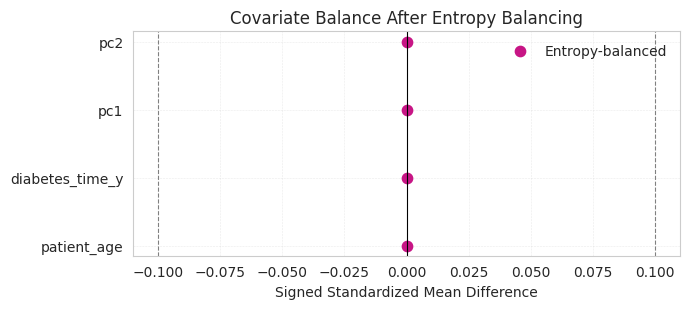

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Define the covariates used in entropy balancing
covars_bal = ["patient_age", "diabetes_time_y", "pc1", "pc2"]

# Define a function to compute signed standardized mean differences
def get_signed_smd(data, treat_col, covars, w=None):
    treated = data[data[treat_col] == 1]
    control = data[data[treat_col] == 0]

    if w is None:
        mean_t = treated[covars].mean()
        mean_c = control[covars].mean()
        var_t = treated[covars].var()
        var_c = control[covars].var()
    else:
        wt_t = treated[w]
        wt_c = control[w]
        mean_t = (treated[covars].multiply(wt_t, axis=0)).sum() / wt_t.sum()
        mean_c = (control[covars].multiply(wt_c, axis=0)).sum() / wt_c.sum()
        var_t = ((treated[covars] - mean_t)**2).multiply(wt_t, axis=0).sum() / wt_t.sum()
        var_c = ((control[covars] - mean_c)**2).multiply(wt_c, axis=0).sum() / wt_c.sum()

    smd = (mean_t - mean_c) / np.sqrt(0.5 * (var_t + var_c))
    return smd

# Compute signed SMDs using entropy balancing weights
smd_eb = get_signed_smd(df_full, "insuline", covars_bal, w="w_eb")

# Plotting
plt.figure(figsize=(7, 3.2))
positions = np.arange(len(covars_bal))

plt.scatter(smd_eb.values, positions, color="mediumvioletred", s=55, label="Entropy-balanced")
plt.axvline(0, color="black", lw=0.8)
plt.axvline(0.1, color="grey", linestyle="--", lw=0.8)
plt.axvline(-0.1, color="grey", linestyle="--", lw=0.8)

plt.yticks(positions, covars_bal)
plt.xlabel("Signed Standardized Mean Difference")
plt.title("Covariate Balance After Entropy Balancing")
plt.legend(frameon=False)
plt.grid(True, linestyle="--", linewidth=0.4, alpha=0.4)
plt.tight_layout()
plt.show()

In [20]:
# cell 17
# ---------------- EB balance diagnostics & inference ------------------------
import statsmodels.api as sm

# helper to compute weighted SMDs -------------------------------------------
def weighted_smd(df, treat, vars_, w):
    smd = {}
    t  = df[treat].values.astype(bool)
    wt = df[w].values
    for v in vars_:
        x = df[v].values
        m1, m0 = (wt[t] * x[t]).sum() / wt[t].sum(), (wt[~t] * x[~t]).sum() / wt[~t].sum()
        v1, v0 = ((wt[t] * (x[t] - m1)**2).sum() / wt[t].sum(),
                  (wt[~t]*(x[~t]- m0)**2).sum() / wt[~t].sum())
        smd[v] = abs(m1-m0) / np.sqrt(.5*(v1+v0))
    return pd.Series(smd).sort_values()

# ── balance check with EB weights ───────────────────────────────────────────
covars_all = ["patient_age","diabetes_time_y","pc1","pc2"]
eb_smd = weighted_smd(df_full, "insuline", covars_all, "w_eb")
print("📏  Absolute SMDs (EB-weighted):")
display(eb_smd)

# ── doubly–robust (WLS) estimate with EB weights ───────────────────────────
X_dr = sm.add_constant(df_full[["insuline"] + covars_all])   # treatment + adj.
model = sm.WLS(df_full["DR_ICDR"], X_dr, weights=df_full["w_eb"])
res   = model.fit(cov_type="HC3")

ate_eb_dr   = res.params["insuline"]
ci_low, ci_hi = res.conf_int().loc["insuline"]

print(f"\n📊  Doubly-robust EB-ATE : {ate_eb_dr:+.3f} "
      f"[{ci_low:+.3f}, {ci_hi:+.3f}]  "
      f"p = {res.pvalues['insuline']:.2e}")

📏  Absolute SMDs (EB-weighted):


,0
pc2,1.087279e-11
pc1,2.481749e-11
patient_age,2.598609e-11
diabetes_time_y,2.046747e-10



📊  Doubly-robust EB-ATE : +0.715 [+0.132, +1.298]  p = 1.62e-02


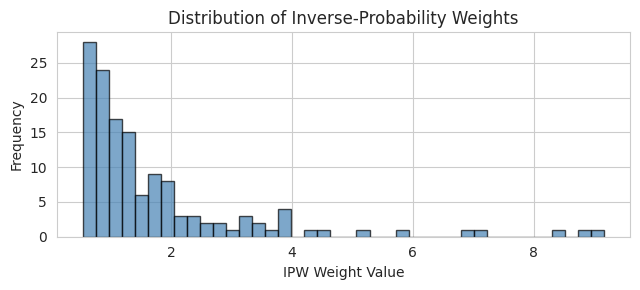

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.5, 3.0))
plt.hist(df_full["w_stab"], bins=40, color="steelblue", alpha=0.7, edgecolor='black')
plt.xlabel("IPW Weight Value")
plt.ylabel("Frequency")
plt.title("Distribution of Inverse-Probability Weights")
plt.tight_layout()
plt.show()